<a href="https://colab.research.google.com/github/lala991204/DL-self-study/blob/master/tensorflow/4_5_object_detection_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as tfhub
import matplotlib.pyplot as plt

이미 학습이 완료된 딥러닝 모델을 사용해보자. 우선, 원하는 이미지를 가져와 model input 형태에 맞게 전처리한다.

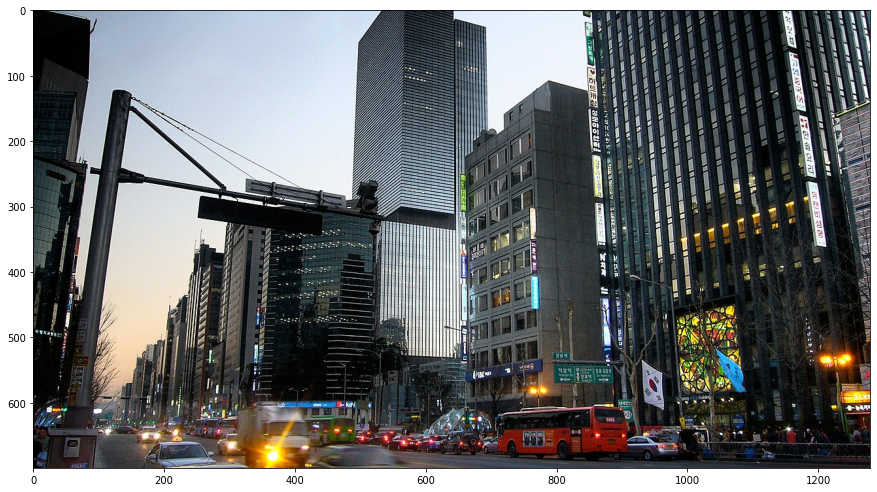

In [ ]:
# sample image
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)           # file 객체를 string으로 변환
img = tf.image.decode_jpeg(img, channels=3)           # 문자(string)를 숫자(unit8) 텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)      # 0~1 범위로 정규화

plt.figure(figsize=(15,10))
plt.imshow(img)

In [ ]:
img_input = tf.expand_dims(img, 0)         # batch_size 추가
img_input.shape

TensorShape([1, 700, 1280, 3])

In [ ]:
# TensorFlow Hub에서 model 가져오기 - FasterRCNN + InceptionResNet V2
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

# model 시그니처(용도) 확인 => 이 모델은 'default' 하나만 제공함.
model.signatures.keys()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7FEED5FAE350>}))

In [ ]:
# 객체탐지 모델 생성
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction pruned(images) at 0x7FEED5FAE350>

In [ ]:
# model 이용하여 예측(추론)
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_names', 'detection_boxes', 'detection_scores', 'detection_class_entities', 'detection_class_labels'])

In [ ]:
# 탐지한 객체의 개수
len(result["detection_scores"])

100

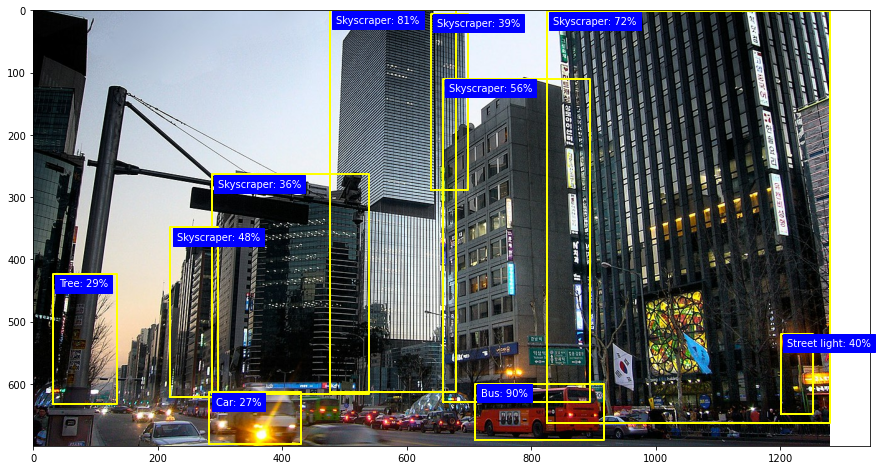

In [ ]:
# 객체 탐지 결과 시각화
boxes = result["detection_boxes"]         # Bounding Box 좌표 예측 값
labels = result["detection_class_entities"]      # 분류 예측 값
scores = result["detection_scores"]            # 신뢰도(confidence)

# sample image 가로,세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# detect할 최대 객체 수
obj_to_detect = 10

# 시각화
plt.figure(figsize=(15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):
    if scores[i] >=0.2:
        (ymax, xmin, ymin, xmax) = (boxes[i][0] * img_height, boxes[i][1] * img_width,
                                    boxes[i][2] * img_height, boxes[i][3] * img_width)
        plt.imshow(img)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                 color='yellow', linewidth=2)
        
        class_name = labels[i].numpy().decode('utf-8')
        infer_score = int(scores[i].numpy() * 100)
        annotation = '{}: {}%'.format(class_name, infer_score)
        plt.text(xmin+10, ymax+20, annotation,
                 color='white', backgroundcolor='blue', fontsize=10)